In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bosonStar import *
from util import *

from ctypes import *
file = "./testing.so"
my_func = CDLL(file)

#Middle
massInCU = 2e-77
aInCU = 1e-73
totalMassInCU = 0.1
dtInCU = 2500.0
bigT = 20000

/home/kklee/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A2=  -0.3197640202007044  X= 20.65212130424261
A2=  -0.4847073570464445  X= 20.0997201994404
A2=  -0.4996237064856289  X= 40.0
A2=  -0.5019378672755319  X= 16.740033480066963
A2=  -0.5018381151828868  X= 18.401316802633605
A2=  -0.5018730652697496  X= 15.347950695901392
A2=  -0.5019295973148135  X= 22.058364116728235
A2=  -0.5019295973148135  X= 22.058364116728235
MU= 0.3181619365115217 MASS= 0.09999012221832808
FAR POINT: 156400 500000


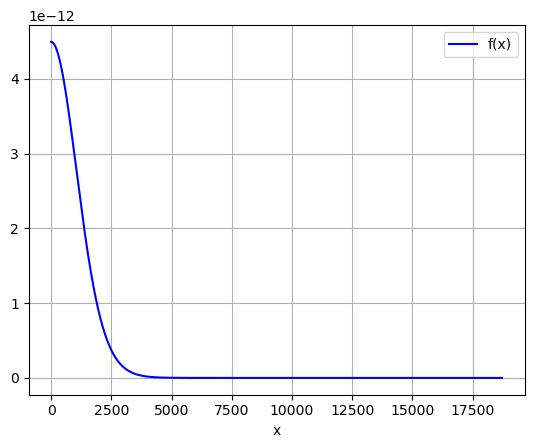

(450,)


In [2]:
allThings = outputProfile(massInCU, aInCU, totalMassInCU, 500)
#Hot Fix
x = allThings["x"][1::2]
psi = allThings["profile"][1::2]

dx = x[1]-x[0]
for i in range(200):
    x = np.append(x, x[-1]+dx)
    psi = np.append(psi, psi[-1])

print(x.shape)

In [3]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 3.8684718785837514e+40
Omega: 3.656129092998465e-43
Epsilon (Should be 1): 1.0000000000000002
Delta: 14.839459489461666
New G: 1.180886665279879


In [4]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
x = np.concatenate((np.flip(-x), x))

psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
psi = np.concatenate((np.flip(psi), psi))
normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
psi = psi/normalization
psi = psi.astype(complex)

'''
for index, value in enumerate(psi):
    if(value<1e-8):
        psi[index] = 0
psi = psi.astype(complex)
'''

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print(dt)

[0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+0

In [5]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [6]:
def setupT():
    global T, TSph
    for i in range(size):
        if i==0:
            T[i][i] = -1.0
            T[i][i+1] = 1.0
            TSph[i][i+1] = 1.0/2.0/x[i] #What should it be?
            TSph[i][i] = -1.0/2.0/x[i]
        elif i==size-1:
            T[i][i] = -1.0
            T[i][i-1] = 1.0
            TSph[i][i-1] = -1.0/2.0/x[i]
            TSph[i][i] = 1.0/2.0/x[i]
        else:
            T[i][i] = -2.0
            T[i][i+1] = 1.0
            T[i][i-1] = 1.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i-1] = -1.0/2.0/x[i]

    T = -1.0/2.0/dx/dx*T
    TSph = -1.0/dx*TSph

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i])*np.absolute(psi[i])

def setupV2Grav():
    global V2Grav, phi, psi

    rho = np.absolute(psi)[size//2:]*np.absolute(psi)[size//2:]
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi)[size//2:])
    my_func.findGravRho(rho_c, phi_c, c_int(size//2), c_double(dx))
    for i in range(size//2):
        place = int(size//2 + i)
        phi[place] = phi_c[i] * GM

    for i in range(size//2):
        V2Grav[i][i] = phi[size-i-1]
        V2Grav[size-i-1][size-i-1] = phi[size-i-1]
            
        phi[i] = phi[size-i-1] #Regulate

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+TSph+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+TSph+Q+V2Grav)

0 0.0 0.058365132392834335 1.0000896415027498
1 0.08351027137908527 0.058367852518001924 1.0000896446154637
2 0.16702054275817055 0.058364751894558184 1.000089641067347
3 0.2505308141372558 0.058368813360821344 1.0000896457150168
4 0.3340410855163411 0.05837039722106154 1.0000896475275682
5 0.4175513568954264 0.058371969537666615 1.0000896493269573
6 0.5010616282745116 0.05837732217350143 1.0000896554529808
7 0.5845718996535969 0.058380277637269794 1.0000896588357118
8 0.6680821710326822 0.05838572150359483 1.0000896650670388
9 0.7515924424117675 0.05839219580705061 1.000089672478613
10 0.8351027137908528 0.058397792150072805 1.0000896788857883
11 0.9186129851699381 0.058406168637252884 1.0000896884770598
12 1.0021232565490232 0.058414005425879593 1.0000896974516094
13 1.0856335279281086 0.058422736498044955 1.0000897074516946
14 1.1691437993071938 0.058433152312031965 1.0000897193833442
15 1.2526540706862792 0.05844293926168773 1.000089730596548
16 1.3361643420653644 0.058454568525869

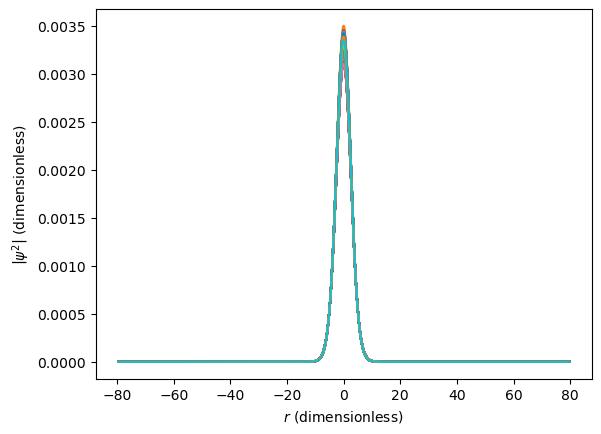

In [7]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()


#Record
gravitationalForce = []
pressureGradient = []
quantumPressure = []

hello = []
ts = []
oldGM = GM
newGM = GM*1.1
for t in range(bigT):
    #Pertubation
    if(t*dt<3.0):
        GM = newGM
    if(t*dt>=3.0):
        GM = oldGM

    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    #Regulate
    for i in range(size//2):
        psi[i] = psi[size-i-1]

    normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
    if(normalization >= 1.01):
        break
    print(t, t*dt, np.absolute(psi[size//2]), normalization)
    if(GM == oldGM):
        hello.append(np.absolute(psi[size//2])*np.absolute(psi[size//2]))
        ts.append(t*dt)

        #Record
        rho0 = (np.absolute(psi[size//2 + 14])*np.absolute(psi[size//2 + 14]))/Ra/Ra/Ra*totalMass
        rho1 = (np.absolute(psi[size//2 + 15])*np.absolute(psi[size//2 + 15]))/Ra/Ra/Ra*totalMass
        rho2 = (np.absolute(psi[size//2 + 16])*np.absolute(psi[size//2 + 16]))/Ra/Ra/Ra*totalMass
        rho3 = (np.absolute(psi[size//2 + 17])*np.absolute(psi[size//2 + 17]))/Ra/Ra/Ra*totalMass
        Q0 = -((np.sqrt(rho0) -2*np.sqrt(rho1) + np.sqrt(rho2))/(dx*Ra)/(dx*Ra) + 2.0/(x[size//2 + 15]*Ra)*(np.sqrt(rho1)-np.sqrt(rho0))/(dx*Ra))/np.sqrt(rho1)/2.0/m
        Q1 = -((np.sqrt(rho1) -2*np.sqrt(rho2) + np.sqrt(rho3))/(dx*Ra)/(dx*Ra) + 2.0/(x[size//2 + 16]*Ra)*(np.sqrt(rho2)-np.sqrt(rho1))/(dx*Ra))/np.sqrt(rho2)/2.0/m

        gravitationalForce.append((phi[size//2 + 16]-phi[size//2 + 15])/dx)
        pressureGradient.append(4.0*np.pi*a/m/m/m*(rho2-rho1)/(dx*Ra)/Ra/omegaA/omegaA)
        quantumPressure.append((Q1-Q0)/m/(dx*Ra)/Ra/omegaA/omegaA)

    if t%100 == 0:
        plt.plot(x, np.absolute(psi)*np.absolute(psi))

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

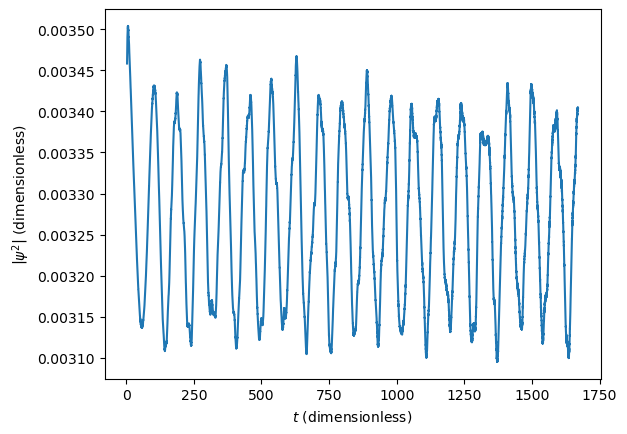

In [8]:
plt.plot(ts, hello)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

Text(0.5, 0, 'f (1/s)')

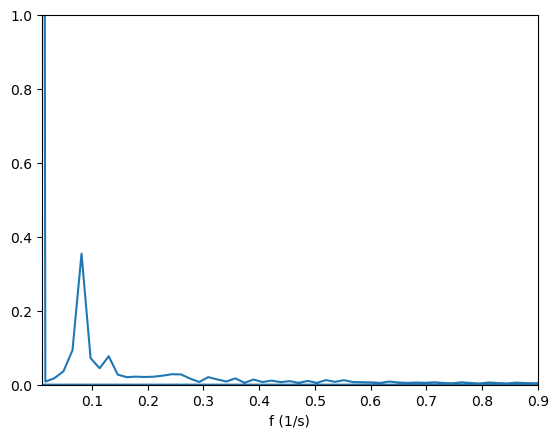

In [9]:
sp = np.fft.fft(hello[:5000])
freq = np.fft.fftfreq(len(hello[:5000]), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.9)
plt.ylim(0.0,1.0)
plt.xlabel("f (1/s)")

In [10]:
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.07 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.08120680000000001 0.35449306156904226
0.12993088000000003 0.07702495696844301


[6.93200410e-06 6.91008269e-06 6.85980856e-06 6.80206028e-06
 6.72499316e-06 6.61192468e-06 6.45702377e-06 6.29831727e-06
 6.14095936e-06 5.94609292e-06 5.72343164e-06 5.48178873e-06
 5.22621045e-06 4.96309335e-06 4.71401671e-06 4.44161238e-06
 4.13019137e-06 3.82208420e-06 3.52875601e-06 3.23712131e-06
 2.94683499e-06 2.69175342e-06 2.46448373e-06 2.26437451e-06
 2.08598013e-06 1.97200301e-06 1.94590529e-06 1.97438104e-06
 2.03821875e-06 2.12277081e-06 2.18377975e-06 2.24134628e-06
 2.31267385e-06 2.38243768e-06 2.42070369e-06 2.43306627e-06
 2.44110722e-06 2.43311035e-06 2.42082153e-06 2.36446673e-06
 2.23325015e-06 2.12328914e-06 2.03431907e-06 1.89981552e-06
 1.74971913e-06 1.60327871e-06 1.46576710e-06 1.32232101e-06
 1.16035913e-06 9.73768108e-07 8.06915569e-07 6.62475585e-07
 5.45275311e-07 4.46362421e-07 3.45256971e-07 2.94017628e-07
 3.35069739e-07 4.06478146e-07 4.57282604e-07 5.00891499e-07
 5.59887810e-07 6.24494023e-07 6.99659198e-07 7.83072308e-07
 8.57052496e-07 9.134480

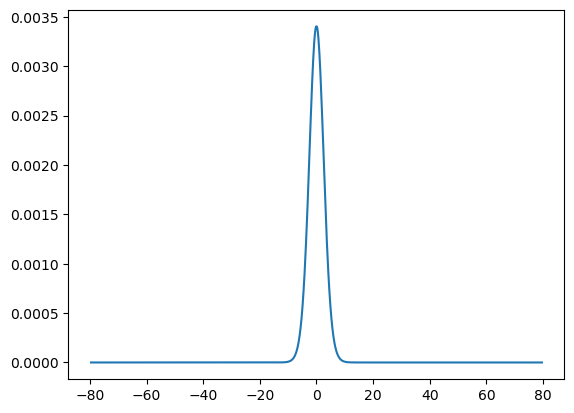

In [11]:
plt.plot(x, np.absolute(psi)*np.absolute(psi))
print(np.absolute(psi))

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?

In [12]:
print(psi)

[ 6.19481525e-06-3.11077882e-06j  6.16213705e-06-3.12686902e-06j
  6.10978200e-06-3.11890004e-06j  6.06264908e-06-3.08420332e-06j
  5.98863208e-06-3.05970894e-06j  5.86901832e-06-3.04502413e-06j
  5.71849711e-06-2.99865750e-06j  5.56175526e-06-2.95561817e-06j
  5.39076447e-06-2.94126507e-06j  5.17577383e-06-2.92700977e-06j
  4.93615594e-06-2.89690081e-06j  4.68933362e-06-2.83904172e-06j
  4.42712396e-06-2.77738170e-06j  4.14444473e-06-2.73054453e-06j
  3.86122370e-06-2.70423835e-06j  3.56099974e-06-2.65465655e-06j
  3.22136323e-06-2.58482101e-06j  2.86787753e-06-2.52657992e-06j
  2.50457054e-06-2.48580881e-06j  2.12185382e-06-2.44472713e-06j
  1.73927196e-06-2.37881683e-06j  1.38811018e-06-2.30622779e-06j
  1.04578849e-06-2.23159281e-06j  6.99607094e-07-2.15358813e-06j
  3.27841438e-07-2.06005658e-06j -4.70961925e-08-1.97144054e-06j
 -3.63976325e-07-1.91156183e-06j -6.33185287e-07-1.87009542e-06j
 -9.06016682e-07-1.82577913e-06j -1.15304624e-06-1.78231318e-06j
 -1.34464039e-06-1.720708